## 3-7-6. 종합예제

In [1]:
import numpy as np
from netCDF4 import Dataset
from datetime import date, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
#import cartopy.crs as ccrs
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.ticker import MultipleLocator, FixedLocator, FuncFormatter

In [2]:
minlat = -30
maxlat = 60
minlon = 120
maxlon = 280
startyear = 2013
startmonth = 11
endyear = 2015
endmonth = 4

In [22]:
def get_anom(varname):
    global minlat, maxlat, minlon, maxlon, startyear, startmonth, endyear, endmonth
    
    if varname == "sst":
        file_var = Dataset(varname+".mnmean1.nc","r")
        file_varclim = Dataset(varname+".mon.ltm.1981-2010.nc","r")
    else:
        file_var = Dataset(varname+".mon.mean.nc","r")
        file_varclim = Dataset(varname+".mon.ltm.nc","r")
        
    
    lat = np.squeeze(file_var.variables["lat"][:])
    ind_lat = np.logical_and(lat >=minlat, lat<=maxlat)
    lat = lat[ind_lat]
    nlat = len(lat)
    lon = np.squeeze(file_var['lon'][:])
    ind_lon = np.logical_and(lon >=minlon, lon<=maxlon)
    lon = lon[ind_lon]
    nlon = len(lon)
    
    time = np.squeeze(file_var.variables['time'][:])
    if varname =="sst":
        time = np.array([date(1800,1,1)+timedelta(days = x) for x in time])
    else :
        time = np.array([date(1800,1,1)+timedelta(hours = x) for x in time])
    
    year = np.array([x.year for x in time])
    month = np.array([x.month for x in time])
    
    ind_start = int(np.where(time == date (startyear, startmonth, 1))[0])
    ind_end = int(np.where(time == date(endyear, endmonth, 1))[0])
    print(ind_start)
    print(ind_end)
    ntime = ind_end - ind_start+1
    print(ntime)
    time = time[ind_start:ind_end+1]
    year = year[ind_start:ind_end+1]
    month = month[ind_start:ind_end+1]
    
    var=np.squeeze(file_var.variables[varname][ind_start:ind_end+1, ind_lat, ind_lon])
    if varname == "sst":
        landmask = var[0,:,:].mask
        print("landmask",landmask)
        var[:,landmask] = np.nan
    
    var_clim = np.squeeze(file_varclim.variables[varname][:,ind_lat, ind_lon])
    
    var_anom = np.zeros(var.shape, np.float32)
    for t in range(ntime):
        var_anom[t,:,:] = var[t,:,:] - var_clim[month[t]-1,:,:]
        
    
    var_anom2 = np.zeros((int(ntime/3), nlat, nlon), np.float32)
    for t in range(int(ntime/3)):
        var_anom2[t,:,:] = np.mean(var_anom[(3*t):(3*(t+1)), :,:], axis = 0)
        
    
    print(varname, ":", np.nanmin(var_anom2), np.nanmax(var_anom2), var_anom2.shape)
    
    return(lat,lon, var_anom2)

In [23]:
lat, lon, uwnd_anom = get_anom('uwnd')
_, _, vwnd_anom = get_anom('vwnd')
_, _, slp_anom = get_anom('slp')
lat_sst, lon_sst, sst_anom = get_anom('sst')

790
807
18
uwnd : -4.66635 3.7996404 (6, 37, 65)
790
807
18
vwnd : -4.4754686 3.2520761 (6, 37, 65)
790
807
18
slp : -6.370402 9.669475 (6, 37, 65)
1918
1935
18
landmask [[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]
sst : -1.5320364 2.7644393 (6, 46, 81)


In [5]:
lon2d, lat2d = np.meshgrid(lon,lat)
lon2d_sst, lat2d_sst = np.meshgrid(lon_sst, lat_sst)

In [6]:
cmap_hot = cm.get_cmap('hot', 10)
cmap_hot = cmap_hot(np.arange(10))
yellowred = cmap_hot[2:][::-1]

cmap_winter = cm.get_cmap('winter',10)
cmap_winter = cmap_winter(np.arange(10))
blue = cmap_winter[0]

cmap_hsv = cm.get_cmap('hsv',10)
cmap_hsv = cmap_hsv(np.arange(10))
skyblue = cmap_hsv[5]

cmap_binary = cm.get_cmap('binary',10)
cmap_binary = cmap_binary(np.arange(10))
white = cmap_binary[0]

bluewhite = LinearSegmentedColormap.from_list('bluewhite', [blue, skyblue, white], N=8)
bluewhite = bluewhite(np.arange(8))

newcolors = np.vstack((bluewhite, yellowred))
cmap_new = ListedColormap(newcolors, name = 'new_cmap')

In [7]:
def lon_format(x,pos):
    if x> 180:
        return("%dW" %(360-x))
    
    elif 0< x <180:
        return("%dE" %x)
    
    elif x == 180:
        return("180")
    
    else:
        return("0")

In [8]:
def lat_format(x, pos):
    if x>0 :
        return("%dN" %x)
    elif x<0 :
        return("%dS" %x)
    else:
        return("0")

In [9]:
def cbar_format(x):
    
    if x%1 ==0:
        return("%d" %x)
    else :
        return("%.1f" %x)

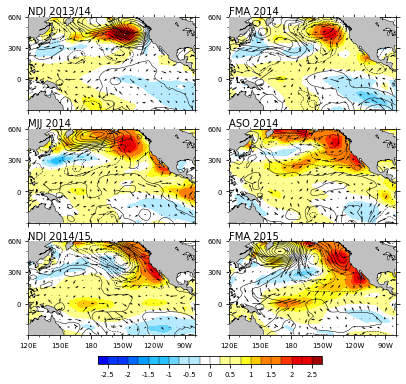

In [10]:
fig, ax = plt.subplots(3,2, figsize = (6,5.5))
titles = ["NDJ 2013/14", "FMA 2014", "MJJ 2014", "ASO 2014", "NDJ 2014/15", "FMA 2015"]

for i in range(3):
    for j in range(2):
        index = 2*i+j
        
        m = Basemap(projection = 'cyl', resolution = 'c', ax = ax[i][j],
                   llcrnrlon = minlon, llcrnrlat = minlat, urcrnrlon = maxlon, urcrnrlat = maxlat)
        m.drawcoastlines(linewidth=0.5, zorder =11)
        m.fillcontinents(color = 'silver', zorder =10)
        
        contour_levels = np.arange(-2.75,2.75+0.25,0.25)
        image = ax[i][j].contourf(lon2d_sst, lat2d_sst, sst_anom[index,:,:], contour_levels, cmap = cmap_new)
        contour_levels_slp = np.arange(-16,16+0.8,0.8)
        ax[i][j].contour(lon2d, lat2d, slp_anom[index,:,:], contour_levels_slp, colors= 'k', linewidths = 0.5)
        
        interval = 3
        ax[i][j].quiver(lon2d[::interval,::interval], lat2d[::interval, ::interval],
                       uwnd_anom[index,::interval, ::interval], vwnd_anom[index, ::interval, ::interval], scale = 40, scale_units = 'width')
        
        ax[i][j].xaxis.set_major_locator(MultipleLocator(30))
        ax[i][j].xaxis.set_major_formatter(FuncFormatter(lon_format))
        ax[i][j].xaxis.set_minor_locator(MultipleLocator(10))
        
        ax[i][j].yaxis.set_major_locator(FixedLocator(np.arange(minlat+30, maxlat+30, 30)))
        ax[i][j].yaxis.set_major_formatter(FuncFormatter(lat_format))
        ax[i][j].yaxis.set_minor_locator(MultipleLocator(10))
        
        ax[i][j].tick_params(which = 'major', labelsize=7, top=True, right = True)
        ax[i][j].tick_params(which = 'minor', top =True, right = True)
        if index<4:
            ax[i][j].tick_params(labelbottom = False)
        
        ax[i][j].text(minlon, maxlat+2, titles[index])
        
caxes = fig.add_axes([0.26,0.05,0.52,0.02])
cbar= fig.colorbar(image, cax=caxes, orientation = 'horizontal', ticks = contour_levels[1::2], drawedges = True)
cbar.ax.tick_params(labelsize=7)

cbar_ticks = [cbar_format(x) for x in contour_levels[1::2]]
cbar.set_ticklabels(cbar_ticks)

plt.subplots_adjust(top = 0.95, bottom = 0.1, left = 0.1, right = 0.95, wspace = 0.2, hspace = 0)



In [11]:
varname = "uwnd"

In [12]:
if varname == "sst":
    file_var = Dataset(varname+".mnmean1.nc","r")
    file_varclim = Dataset(varname+".mon.ltm.1981-2010.nc","r")
else:
    file_var = Dataset(varname+".mon.mean.nc","r")
    file_varclim = Dataset(varname+".mon.ltm.nc","r")
        
 

In [13]:
file_var

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description: Data from NCEP initialized reanalysis (4x/day).  These are the 0.9950 sigma level values
    platform: Model
    Conventions: COARDS
    NCO: 20121012
    history: Thu May  4 20:11:28 2000: ncrcat -d time,0,623 /Datasets/ncep.reanalysis.derived/surface/uwnd.mon.mean.nc uwnd.mon.mean.nc
Thu May  4 18:12:51 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/surface/uwnd.mon.mean.nc ./surface/uwnd.mon.mean.nc
Mon Jul  5 23:51:33 1999: ncrcat ./uwnd.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface/uwnd.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/surface/uwnd.mon.mean.nc
/home/hoop/crdc/cpreanjuke2farm/cpreanjuke2farm Thu Oct 26 23:42:16 1995 from pre.sig995.85.nc
created 95/02/06 by Hoop (netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2014/09
    title: monthly mean uwnd.sig995 from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
 

In [14]:
lat = np.squeeze(file_var.variables["lat"][:])
ind_lat = np.logical_and(lat >=minlat, lat<=maxlat)
lat = lat[ind_lat]
nlat = len(lat)
print(lat)

[ 60.   57.5  55.   52.5  50.   47.5  45.   42.5  40.   37.5  35.   32.5
  30.   27.5  25.   22.5  20.   17.5  15.   12.5  10.    7.5   5.    2.5
   0.   -2.5  -5.   -7.5 -10.  -12.5 -15.  -17.5 -20.  -22.5 -25.  -27.5
 -30. ]


In [15]:
lon = np.squeeze(file_var['lon'][:])
ind_lon = np.logical_and(lon >=minlon, lon<=maxlon)
lon = lon[ind_lon]
nlon = len(lon)
print(lon)

[120.  122.5 125.  127.5 130.  132.5 135.  137.5 140.  142.5 145.  147.5
 150.  152.5 155.  157.5 160.  162.5 165.  167.5 170.  172.5 175.  177.5
 180.  182.5 185.  187.5 190.  192.5 195.  197.5 200.  202.5 205.  207.5
 210.  212.5 215.  217.5 220.  222.5 225.  227.5 230.  232.5 235.  237.5
 240.  242.5 245.  247.5 250.  252.5 255.  257.5 260.  262.5 265.  267.5
 270.  272.5 275.  277.5 280. ]


In [16]:
time = np.squeeze(file_var.variables['time'][:])
time = np.array([date(1800,1,1)+timedelta(hours = x) for x in time])
print(time.shape) 

(894,)


In [17]:
year = np.array([x.year for x in time])
month = np.array([x.month for x in time])

print(year)
print(month)

[1948 1948 1948 1948 1948 1948 1948 1948 1948 1948 1948 1948 1949 1949
 1949 1949 1949 1949 1949 1949 1949 1949 1949 1949 1950 1950 1950 1950
 1950 1950 1950 1950 1950 1950 1950 1950 1951 1951 1951 1951 1951 1951
 1951 1951 1951 1951 1951 1951 1952 1952 1952 1952 1952 1952 1952 1952
 1952 1952 1952 1952 1953 1953 1953 1953 1953 1953 1953 1953 1953 1953
 1953 1953 1954 1954 1954 1954 1954 1954 1954 1954 1954 1954 1954 1954
 1955 1955 1955 1955 1955 1955 1955 1955 1955 1955 1955 1955 1956 1956
 1956 1956 1956 1956 1956 1956 1956 1956 1956 1956 1957 1957 1957 1957
 1957 1957 1957 1957 1957 1957 1957 1957 1958 1958 1958 1958 1958 1958
 1958 1958 1958 1958 1958 1958 1959 1959 1959 1959 1959 1959 1959 1959
 1959 1959 1959 1959 1960 1960 1960 1960 1960 1960 1960 1960 1960 1960
 1960 1960 1961 1961 1961 1961 1961 1961 1961 1961 1961 1961 1961 1961
 1962 1962 1962 1962 1962 1962 1962 1962 1962 1962 1962 1962 1963 1963
 1963 1963 1963 1963 1963 1963 1963 1963 1963 1963 1964 1964 1964 1964
 1964 

In [18]:
ind_start = int(np.where(time == date (startyear, startmonth, 1))[0]) #2013.11월
ind_end = int(np.where(time == date(endyear, endmonth, 1))[0]) #2015년 4월
print(ind_start) 
print(ind_end)
ntime = ind_end - ind_start+1
print(ntime)

time = time[ind_start:ind_end+1]
year = year[ind_start:ind_end+1]
month = month[ind_start:ind_end+1]
print(time)
print(year)
print(month)

790
807
18
[datetime.date(2013, 11, 1) datetime.date(2013, 12, 1)
 datetime.date(2014, 1, 1) datetime.date(2014, 2, 1)
 datetime.date(2014, 3, 1) datetime.date(2014, 4, 1)
 datetime.date(2014, 5, 1) datetime.date(2014, 6, 1)
 datetime.date(2014, 7, 1) datetime.date(2014, 8, 1)
 datetime.date(2014, 9, 1) datetime.date(2014, 10, 1)
 datetime.date(2014, 11, 1) datetime.date(2014, 12, 1)
 datetime.date(2015, 1, 1) datetime.date(2015, 2, 1)
 datetime.date(2015, 3, 1) datetime.date(2015, 4, 1)]
[2013 2013 2014 2014 2014 2014 2014 2014 2014 2014 2014 2014 2014 2014
 2015 2015 2015 2015]
[11 12  1  2  3  4  5  6  7  8  9 10 11 12  1  2  3  4]


In [19]:
var=np.squeeze(file_var.variables[varname][ind_start:ind_end+1, ind_lat, ind_lon])

var_clim = np.squeeze(file_varclim.variables[varname][:,ind_lat, ind_lon])

In [20]:
#for t in range(ntime):
#    print(month[t])

month

array([11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4])

In [21]:
var_anom = np.zeros(var.shape, np.float32)
for t in range(ntime):
    var_anom[t,:,:] = var[t,:,:] - var_clim[month[t]-1,:,:]
        
    
var_anom2 = np.zeros((int(ntime/3), nlat, nlon), np.float32)
for t in range(int(ntime/3)):
    var_anom2[t,:,:] = np.mean(var_anom[(3*t):(3*(t+1)), :,:], axis = 0)
        
    
print(varname, ":", np.nanmin(var_anom2), np.nanmax(var_anom2), var_anom2.shape)
    
# return(lat,lon, var_anom2)

uwnd : -4.66635 3.7996404 (6, 37, 65)
